# 动量法
:label:`sec_momentum`

([本节](https://github.com/d2l-ai/d2l-zh/tree/release/chapter_optimization)是机器翻译，欢迎[改进](https://zh.d2l.ai/chapter_appendix/how-to-contribute.html))

在 :numref:`sec_sgd` 中，我们回顾了执行随机梯度下降时发生的情况，即在只有有嘈杂的渐变变可用的情况下执行优化时会发生什么。特别是，我们注意到，对于嘈杂的渐变，我们在面对噪音的情况下选择学习率时需要格外谨慎。如果我们减少速度太快，收敛就会停滞。如果我们太宽松，我们就无法融合到足够好的解决方案，因为噪音不断使我们远离最佳性。

## 基础

在本节中，我们将探讨更有效的优化算法，尤其是针对实践中常见的某些类型的优化问题。

### 漏平均值

上一节看到我们讨论了迷你匹配 SGD 作为加速计算的手段。平均渐变减少了差异量，这也有很好的副作用。迷你匹配随机梯度下降可以通过以下方式计算：

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
$$

为了保持记法简单，在这里我们使用 $\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$ 作为样本 $i$ 的随机梯度下降，使用时间 $t-1$ 时更新的权重 $t-1$。如果我们能够从方差减少的效果中受益，甚至超过了小批量上的渐变平均值，那将是不错的。完成这项任务的一种选择是用 “泄漏的平均值” 取代梯度计算：

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$$

对于大约 $\beta \in (0, 1)$。这有效地将瞬时梯度替换为多个 * 过去 * 渐变的平均值。$\mathbf{v}$ 被称为 * 动量 *。它累积了过去的梯度，类似于向下滚动目标功能景观的重球如何与过去的力量相结合。为了更详细地了解发生了什么，让我们递归地将 $\mathbf{v}_t$ 扩展到

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$

大型 $\beta$ 相当于长期平均值，而较小的 $\beta$ 相对于梯度法只是略有修正。新的梯度替换不再指向特定实例下降最陡的方向，而是指向过去渐变的加权平均值的方向。这使我们能够实现对一批次进行平均值的大部分好处，而无需实际计算其梯度的成本。稍后我们将更详细地重新讨论这个平均程序。

上述推理构成了现在所谓的 * 加速 * 梯度方法的基础，例如具有动量的渐变。在优化问题条件不佳的情况下（例如，有些方向的进展比其他方向慢得多，类似狭窄的峡谷），他们还享受更有效的好处。此外，它们允许我们在随后的渐变中进行平均值，以获得更稳定的下降方向。事实上，即使是对于无噪音凸问题，加速方面也是动量起作用的关键原因之一，以及为什么它运行得如此良好。

正如人们所期望的那样，由于其功效势头，是深度学习及其后优化中一个深入研究的主题。例如，请参阅漂亮的 [解释性文章]（https://distill.pub/2017/momentum/) by :cite:`Goh.2017`，了解深入分析和互动动画。它是由 :cite:`Polyak.1964` 提出的。:cite:`Nesterov.2018` 在凸优化的背景下进行了详细的理论讨论。长期以来，深度学习的势头一直是有益的。例如，有关详细信息，请参阅 :cite:`Sutskever.Martens.Dahl.ea.2013` 之前的讨论。

### 条件不佳的问题

为了更好地了解动量法的几何属性，我们重新审视了梯度下降，尽管客观函数明显不太愉快。回想一下，我们在 :numref:`sec_gd` 中使用了 $f(\mathbf{x}) = x_1^2 + 2 x_2^2$，即中度扭曲的椭球物体。我们通过向 $x_1$ 方向伸展它来进一步扭曲这个函数

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

与之前一样，$f$ 的最低水平为 $(0, 0)$。该函数在 $x_1$ 的方向上 * 非常 * 平坦。让我们看看当我们像以前一样在这个新函数上执行渐变下降时会发生什么。我们选择了 $0.4$ 的学习率。


epoch 20, x1: -0.943467, x2: -0.000073


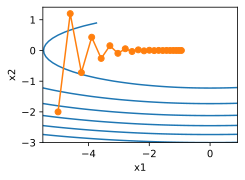

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

从构造来看，$x_2$ 方向的梯度比水平 $x_1$ 方向的渐变 * 高得多，变化快得多。因此，我们陷入了两个不可取的选择：如果我们选择较小的学习率，我们确保解决方案不会朝 $x_2$ 方向发生偏离，但我们背负着在 $x_1$ 方向的缓慢收敛。相反，随着学习率较高，我们朝 $x_1$ 方向快速进展，但在 $x_2$ 中有所不同。下面的例子说明了即使学习率从 $0.4$ 略有提高到 $0.6$，也会发生什么。$x_1$ 方向的收敛有所改善，但整体解决方案质量差得多。


epoch 20, x1: -0.387814, x2: -1673.365109


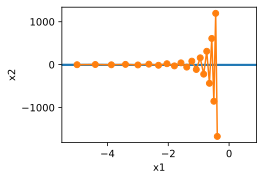

In [2]:
eta = 0.6
d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

### 动量方法

动量方法使我们能够解决上面描述的梯度下降问题。看上面的优化跟踪，我们可能会直觉到过去的平均渐变效果会很好。毕竟，在 $x_1$ 方向上，这将聚合良好对齐的渐变，从而增加我们在每一步中覆盖的距离。相反，在梯度振荡的 $x_2$ 方向，由于相互取消对方的振荡，聚合梯度将减小步长大小。使用 $\mathbf{v}_t$ 而不是梯度 $\mathbf{g}_t$ 可以生成以下更新方程式：

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

请注意，对于 $\beta = 0$，我们恢复常规梯度下降。在深入研究数学属性之前，让我们快速看一下算法在实践中的行为方式。


epoch 20, x1: 0.007188, x2: 0.002553


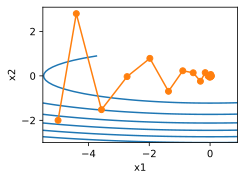

In [3]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

正如我们所看到的那样，即使我们以前使用的学习率相同，势头仍然很好地收敛。让我们看看当我们降低动量参数时会发生什么。将其减半至 $\beta = 0.25$ 会导致一条几乎没有收敛的轨迹。尽管如此，它比没有动力要好得多（当解决方案分歧时）。


epoch 20, x1: -0.126340, x2: -0.186632


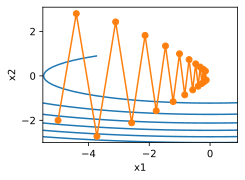

In [4]:
eta, beta = 0.6, 0.25
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

请注意，我们可以将动量与随机梯度下降，特别是迷你匹配随机梯度下降结合起来。唯一的变化是，在这种情况下，我们将梯度 $\mathbf{g}_{t, t-1}$ 替换为 $\mathbf{g}_t$。最后，为了方便起见，我们在时间 $t=0$ 初始化 $\mathbf{v}_0 = 0$。让我们来看看漏洞的平均值对更新实际做了什么。

### 有效样品重量

回想一下 $\mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}$。在限额内，条款加起来为 $\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$。换句话说，我们不是在梯度下降或随机梯度下降方向采取 $\eta$ 大小为 $\eta$ 的一步，同时采取大小为 $\frac{\eta}{1-\beta}$ 的步骤，同时处理可能更好的行为下降方向。这些是两个好处合一。要说明 $\beta$ 不同选择的权重行为，请考虑下面的图表。


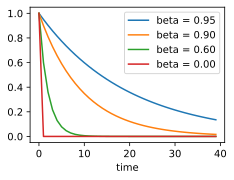

In [5]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

## 实际实验

让我们来看看动量在实践中是如何运作的，即在适当的优化器的环境中使用时。为此，我们需要一个更具可扩展性的实施。

### 从头开始实施

与（迷你匹配）随机梯度下降相比，动量方法需要维持一组辅助变量，即速度。它与梯度（以及优化问题的变量）具有相同的形状。在下面的实施中，我们称之为这些变量 `states`。


In [6]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

In [7]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

让我们看看这在实践中是如何运作的。


loss: 0.243, 0.012 sec/epoch


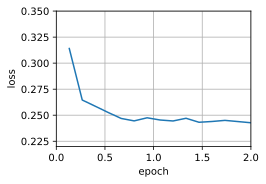

In [8]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

当我们将动量超参数 `momentum` 增加到 0.9 时，它相当于大大增加 $\frac{1}{1 - 0.9} = 10$ 的有效样本数量，即 $\frac{1}{1 - 0.9} = 10$。我们将学习率略微降至 $0.01$，以保持事务的控制。


loss: 0.255, 0.011 sec/epoch


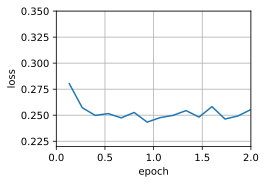

In [9]:
train_momentum(0.01, 0.9)

降低学习率进一步解决了任何非平滑优化问题的问题。将其设置为 $0.005$ 会产生良好的收敛性能。


loss: 0.244, 0.011 sec/epoch


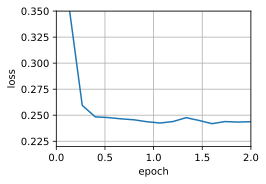

In [10]:
train_momentum(0.005, 0.9)

### 简洁的实施

自从标准 `sgd` 求解器已经建立了势头以来，在 Gluon 没什么可做的。设置匹配参数会产生非常类似的轨迹。


loss: 0.243, 0.012 sec/epoch


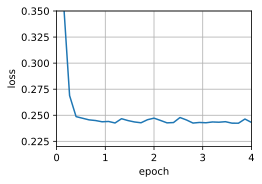

In [11]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

## 理论分析

到目前为止，$f(x) = 0.1 x_1^2 + 2 x_2^2$ 的 2D 例子似乎相当人造。我们现在将看到，这实际上非常代表了人们可能遇到的问题类型，至少在尽量减少凸二次目标函数的情况下是如此。

### 二次凸函数

考虑这个函数

$$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b.$$

这是一个普遍的二次函数。对于正定矩阵 $\mathbf{Q} \succ 0$，即对于具有正特征值的矩阵，最小值为 $\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$，最小值为 $\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$，最小值为 $b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。因此我们可以将 $h$ 重写为

$$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}.$$

梯度由 $\partial_{\mathbf{x}} f(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$ 给出。也就是说，它是由 $\mathbf{x}$ 和最小化器之间的距离乘以 $\mathbf{Q}$。因此，势头还是术语 $\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$ 的线性组合。

由于 $\mathbf{Q}$ 是正确的，因此可以通过 $\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$ 分解为正交（旋转）矩阵 $\mathbf{O}$ 和正特征值的对角矩阵 $\boldsymbol{\Lambda}$ 为正特征值的对角矩阵 $\boldsymbol{\Lambda}$。这使我们能够将变量从 $\mathbf{x}$ 更改为 $\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$，以获得一个非常简化的表达式：

$$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'.$$

这里是 $b' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$。由于 $\mathbf{O}$ 只是一个正交矩阵，因此不会以有意义的方式扰动渐变。以 $\mathbf{z}$ 表示的梯度下降变成

$$\mathbf{z}_t = \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}.$$

这个表达式中的重要事实是渐变下降 * 不会在不同的特征空间之间混合 *。也就是说，如果用 $\mathbf{Q}$ 的特征系统来表示，优化问题是以坐标的方式进行的。这也保持了势头。

$$\begin{aligned}
\mathbf{v}_t & = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
\mathbf{z}_t & = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right) \\
    & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}.
\end{aligned}$$

在这样做的过程中，我们只是证明了以下定理：带有和不带凸二次函数动量的梯度下降分解为朝二次矩阵特征向量方向的坐标优化。

### 标量函数

鉴于上述结果，让我们看看当我们最小化函数 $f(x) = \frac{\lambda}{2} x^2$ 时会发生什么。对于渐变下降我们有

$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$$

每当 $|1 - \eta \lambda| < 1$ 这种优化以指数速度收敛，因为在 $t$ 步骤之后，我们就有 $x_t = (1 - \eta \lambda)^t x_0$。这显示了在我们将学习率 $\eta$ 提高到 $\eta \lambda = 1$ 之前，收敛率最初是如何提高的。除此之外，事情还有分歧，对于 $\eta \lambda > 2$ 而言，优化问题分歧。


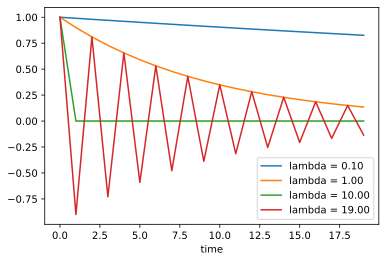

In [12]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
d2l.set_figsize((6, 4))
for lam in lambdas:
    t = torch.arange(20).detach().numpy()
    d2l.plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend();

为了分析动量的收敛情况，我们首先用两个标量重写更新方程：一个用于 $x$，另一个用于动量 $v$。这产生了：

$$
\begin{bmatrix} v_{t+1} \\ x_{t+1} \end{bmatrix} =
\begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix}
\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix}.
$$

我们用 $\mathbf{R}$ 来表示 $2 \times 2$ 管理收敛行为。在 $t$ 步骤之后，最初的选择 $[v_0, x_0]$ 变为 $\mathbf{R}(\beta, \eta, \lambda)^t [v_0, x_0]$。因此，最高可以确定收敛速度的特征值 $\mathbf{R}$。请参阅 [Distill 帖子]（https://distill.pub/2017/momentum/) of :cite:`Goh.2017` 了解精彩动画，参见 :cite:`Flammarion.Bach.2015` 了解详细分析。人们可以表明，$0 < \eta \lambda < 2 + 2 \beta$ 势头收敛。与梯度下降的 $0 < \eta \lambda < 2$ 相比，这是更大范围的可行参数。它还表明，一般而言，$\beta$ 的大值是可取的。进一步的细节需要相当多的技术细节，我们建议感兴趣的读者查阅原始出版物。

## 摘要

* 在过去的渐变中，动量用泄漏的平均值替换渐变。这大大加快了收敛速度。
* 对于无噪音梯度下降和（嘈杂）随机梯度下降都是可取的。
* 动量可防止随机梯度下降的可能性更大的优化过程停滞。
* 由于对过去的数据进行了指数降低，有效梯度数为 $\frac{1}{1-\beta}$。
* 在凸二次问题的情况下，可以对此进行明确的详细分析。
* 实施非常简单，但它需要我们存储额外的状态向量（势头 $\mathbf{v}$）。

## 练习

1. 使用动量超参数和学习率的其他组合，观察和分析不同的实验结果。
1. 试试 GD 和动力来寻找二次问题，其中你有多个特征值，即 $f(x) = \frac{1}{2} \sum_i \lambda_i x_i^2$，例如 $\lambda_i = 2^{-i}$。绘制 $x$ 的值在初始化 $x_i = 1$ 时如何下降。
1. 推导 $h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$ 的最小值和最小值。
1. 当我们用动量执行随机梯度下降时会有什么变化？当我们使用带动量的迷你匹配随机梯度下降时会发生什么？试验参数？


[Discussions](https://discuss.d2l.ai/t/1070)
